Saved merged trajectory to data/pdrPathWithRSSI\PDR_SensorData_3f_90_1_merged.csv
Saved merged trajectory to data/pdrPathWithRSSI\PDR_SensorData_3f_90_2_merged.csv
Saved merged trajectory to data/pdrPathWithRSSI\PDR_SensorData_3f_full_merged.csv


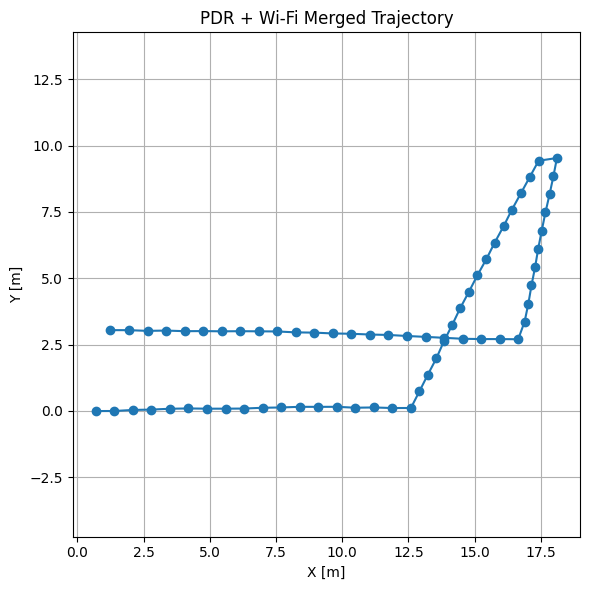

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, savgol_filter
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

FS = 50.0
DT = 1.0 / FS
STEP_LEN = 0.7
OUTPUT_DIR = 'data/pdrPathWithRSSI'
# 처리할 (sensor, wifi) 파일 경로 리스트
DATA_SETS = [
    ('data/rawdata/PDR_SensorData_3f_90_1.csv', 'data/rawdata/RSSIData_3f_90_1.csv'),
    ('data/rawdata/PDR_SensorData_3f_90_2.csv', 'data/rawdata/RSSIData_3f_90_2.csv'),
    ('data/rawdata/PDR_SensorData_3f_full.csv', 'data/rawdata/RSSIData_3f_full.csv'),
]

def load_sensor(csv_path, skiprows=range(1, 50)):
    df = pd.read_csv(csv_path, skiprows=skiprows)
    df['timestamp'] = df['Timestamp'].astype(np.float64)
    cols = ['AccX','AccY','AccZ','GyroX','GyroY','GyroZ','OrientationPitch','timestamp']
    return df[cols]

def detect_steps(acc_x, acc_y, acc_z, window=51, polyorder=3, sigma_scale=0.5):
    acc_norm = np.linalg.norm(np.stack([acc_x, acc_y, acc_z], axis=1), axis=1)
    acc_smooth = savgol_filter(acc_norm, window_length=window, polyorder=polyorder)
    thresh = acc_smooth.mean() + sigma_scale * acc_smooth.std()
    peaks, _ = find_peaks(acc_smooth, height=thresh, distance=int(0.3*FS))
    return peaks

def compute_heading(gyro, pitch):
    rot = R.from_euler('x', -pitch, degrees=False)
    gyro_nav = rot.apply(gyro)
    return np.cumsum(gyro_nav[:,2] * DT)

def build_pdr_trajectory(heading, peaks, step_len=STEP_LEN):
    hdgs = heading[peaks]
    dx = step_len * np.cos(hdgs)
    dy = step_len * np.sin(hdgs)
    return np.cumsum(dx), np.cumsum(dy)

def load_and_merge_wifi(pdr_df, wifi_path, tol_ms=300):
    wifi_df = pd.read_csv(wifi_path)
    wifi_df.rename(columns={wifi_df.columns[0]:'timestamp'}, inplace=True)
    wifi_df['timestamp'] = wifi_df['timestamp'].astype(np.float64)
    wifi_df.sort_values('timestamp', inplace=True)

    merged = pd.merge_asof(
        pdr_df, wifi_df,
        on='timestamp', direction='nearest', tolerance=tol_ms
    )
    rssi_cols = [c for c in merged.columns if c not in ['timestamp','x','y']]
    merged[rssi_cols] = (
        merged[rssi_cols]
        .interpolate(method='linear', limit_direction='both')
        .clip(lower=-100)
    )
    return merged

def process_dataset(sensor_path, wifi_path):
    df = load_sensor(sensor_path)
    acc = df[['AccX','AccY','AccZ']].values
    gyro = df[['GyroX','GyroY','GyroZ']].values
    pitch = np.radians(df['OrientationPitch'].values)
    t_ms = df['timestamp'].values

    peaks = detect_steps(acc[:,0], acc[:,1], acc[:,2])
    heading = compute_heading(gyro, pitch)
    x_raw, y_raw = build_pdr_trajectory(heading, peaks)
    pdr_df = pd.DataFrame({'timestamp': t_ms[peaks], 'x': x_raw, 'y': y_raw})

    merged = load_and_merge_wifi(pdr_df, wifi_path)
    return merged

def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    for sensor_path, wifi_path in DATA_SETS:
        merged = process_dataset(sensor_path, wifi_path)
        base = os.path.splitext(os.path.basename(sensor_path))[0]
        save_path = os.path.join(OUTPUT_DIR, f'{base}_merged.csv')
        merged.to_csv(save_path, index=False)
        print(f'Saved merged trajectory to {save_path}')

    # 전체 결과 시각화 (예시: 첫 번째 데이터셋)
    example = process_dataset(*DATA_SETS[0])
    plt.figure(figsize=(6,6))
    plt.plot(example['x'], example['y'], marker='o', linestyle='-')
    plt.title('PDR + Wi-Fi Merged Trajectory')
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.axis('equal')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()
